In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import e3nn
from e3nn import o3, io
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import open3d as o3d
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io

# plotly.io.renderers.default = "notebook"

from tqdm.notebook import tqdm
from functools import partial, reduce


from utils import load_model, save_model, CustomLRScheduler
from data_generation import SimpleShapeDataset, SimpleShapeUniformRayDataset, BoxesDataset
from model import EncoderDecoder
from visualize import visualize_points, visualize_signal

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu' # for now batch=1 so no need for gpu
device

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


'cpu'

In [2]:
dataset = BoxesDataset(lmax=4)
sphten = io.SphericalTensor(lmax=4, p_arg=1, p_val=1)
len(dataset)

2

In [3]:
visualize_signal(sphten, dataset[0])

In [5]:
model = EncoderDecoder(lmax=4).to(device)

print("number of parameters = ", sum([np.prod(x.shape) for x in model.parameters()]))

/home/shayan/miniconda3/envs/equiv-net/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/home/shayan/miniconda3/envs/equiv-net/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/home/shayan/miniconda3/envs/equiv-net/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/home/shayan/miniconda3/envs

number of parameters =  12216


/home/shayan/miniconda3/envs/equiv-net/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.



In [10]:
def train(
        model,
        dataset,
        loss_fn,        
        epochs=600,
        checkpoint_interval=50,
        initial_rl=1,
        scheduler=None,
        optimizer=None
):
    
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=initial_rl)

    dataloader = DataLoader(dataset, batch_size=len(dataset))

    pbar = tqdm(range(epochs))
    losses = []
    for epoch in pbar:
        for data in dataloader:
            data = data.float().to(device)            
            inp, latent, out = model(data)    
            loss = loss_fn(inp, out)
            optimizer.zero_grad()
            loss.backward()
            max_grad = max([torch.linalg.norm(p.grad).item() for p in model.parameters() if p.grad is not None])
            optimizer.step()
            pbar.set_description(f'Epoch {epoch+1} Loss: {loss.item():.8f} Lr={optimizer.param_groups[0]["lr"]} MaxGrad={max_grad:.4f}')
            losses.append(loss.item())
            
        if epoch % checkpoint_interval == 0:
            name = f'epoch_{epoch}'
            save_model(model, name)
            print(f'saved {name}')

        if scheduler is not None:   
            scheduler.step()
    return losses

In [11]:
save_model(model, 'initial_state')

In [12]:
initial_rl = 1
optimizer = torch.optim.Adam(model.parameters(), lr=initial_rl)
custom_scheduler = CustomLRScheduler(optimizer, initial_rl)
loss_fn = torch.nn.MSELoss(reduction='sum')

  0%|          | 0/600 [00:00<?, ?it/s]

saved epoch_0
saved epoch_50
saved epoch_100
saved epoch_150
saved epoch_200
saved epoch_250
saved epoch_300
saved epoch_350
saved epoch_400
saved epoch_450
saved epoch_500
saved epoch_550


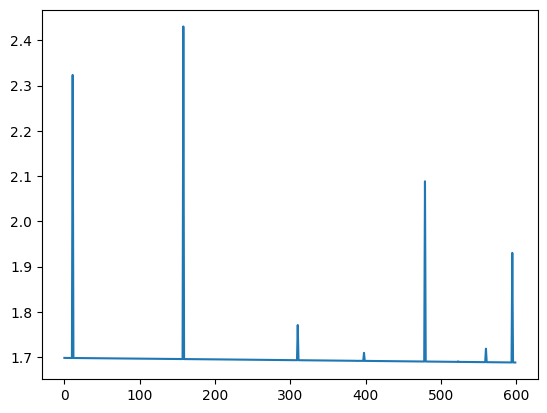

In [27]:
# save_model(model, 'initial_state')
load_model(model, 'initial_state')

custom_scheduler.set_rl(0.01)
losses = train(model=model, dataset=dataset, loss_fn=loss_fn, epochs=600, initial_rl=None, scheduler=custom_scheduler, optimizer=optimizer)
save_model(model, 'final_state')
save_model(model, 'initial_state')

plt.plot(losses)

In [29]:
single_data = dataset[0].to(device)

inp, latent, out = model(single_data)
inp = inp.cpu().detach()
latent = latent.cpu().detach()
out = out.cpu().detach()

print('loss', loss_fn(inp, out))
print('L-inf loss', torch.max(torch.abs(inp - out)))

# sphten = model.model_sphten_repr
fig = make_subplots(rows=1, cols=2, specs=[[{'is_3d': True} for j in range(2)] for i in range(1)])
fig.add_trace(go.Surface(sphten.plotly_surface(out, radius=True)[0]), row=1, col=1)
fig.add_trace(go.Surface(sphten.plotly_surface(inp, radius=True)[0]), row=1, col=2)

loss tensor(4.3432)
L-inf loss tensor(1.5283)
